<a href="https://colab.research.google.com/github/claredavies/MachineLearningCoursework/blob/main/Assignment3/Assignment3HumanActivityRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<html><h1><center style="color:blue">Human Activity Recognition with Smartphones</center></h1></html>

# Load in Libraries

In [60]:
import matplotlib as mlt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap

!python -m pip install 'fsspec>=0.3.3'
import tracemalloc
import pandas as pd
import dask.dataframe as dd
import time

from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import homogeneity_score, completeness_score, \
v_measure_score, adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
%matplotlib inline

pd.set_option('display.max_rows', None)

# Read in Files

Upload zip UCI HAR Dataset.zip

In [61]:
!unzip "UCI HAR Dataset.zip"

Archive:  UCI HAR Dataset.zip
replace UCI HAR Dataset/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [62]:
# get the features from the file features.txt
features = list()
with open('UCI HAR Dataset/features.txt') as f:
    features = [line.split()[1] for line in f.readlines()]
print('No of Features: {}'.format(len(features)))

No of Features: 561


In [63]:
# get the features from the file features.txt
features = list()
with open('UCI HAR Dataset/features.txt') as f:
    features = [line.split()[1] for line in f.readlines()]
print('No of Features: {}'.format(len(features)))

# get the data from txt files to pandas dataffame
X_train = pd.read_csv('UCI HAR Dataset/train/X_train.txt', delim_whitespace=True, header=None)
X_train.columns = [features]
# add subject column to the dataframe
X_train['subject'] = pd.read_csv('UCI HAR Dataset/train/subject_train.txt', header=None, squeeze=True)

y_train = pd.read_csv('UCI HAR Dataset/train/y_train.txt', names=['Activity'], squeeze=True)
y_train_labels = y_train.map({1: 'WALKING', 2:'WALKING_UPSTAIRS',3:'WALKING_DOWNSTAIRS',\
                       4:'SITTING', 5:'STANDING',6:'LAYING'})

# put all columns in a single dataframe
train = X_train
train['Activity'] = y_train
train['ActivityName'] = y_train_labels

No of Features: 561


In [64]:
print('Shape of the data set: ' + str(train.shape))

Shape of the data set: (7352, 564)


# Data Exploration

### 1. Check for Duplicates

In [65]:
print('No of duplicates in train: {}'.format(sum(train.duplicated())))

/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:208: PerformanceWarning: indexing past lexsort depth may impact performance.
  res = shell.run_cell(code, store_history=store_history, silent=silent)


No of duplicates in train: 0


### 2. Checking for NaN/null values

In [66]:
print('We have {} NaN/Null values in train'.format(train.isnull().values.sum()))

We have 0 NaN/Null values in train


In [67]:
train.to_csv('train.csv', index=False)
train = pd.read_csv('train.csv')

In [68]:
columns = train.columns

# Removing '()' from column names
columns = columns.str.replace('[()]','')
columns = columns.str.replace('[-]', '')
columns = columns.str.replace('[,]','')

train.columns = columns

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


Activity per Subject

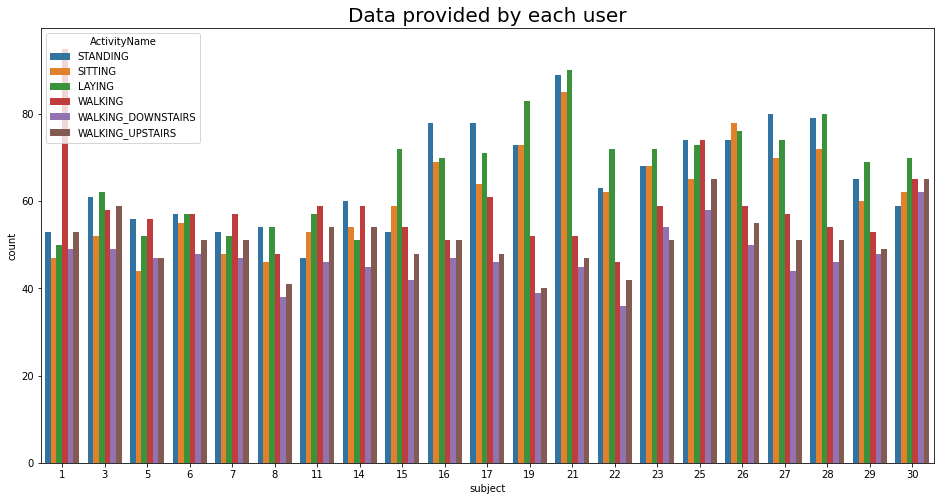

In [69]:
plt.figure(figsize=(16,8))
plt.title('Data provided by each user', fontsize=20)
sns.countplot(x='subject',hue='ActivityName', data = train)
plt.show()

Activity Count

Text(0.5, 1.0, 'Count per Activity')

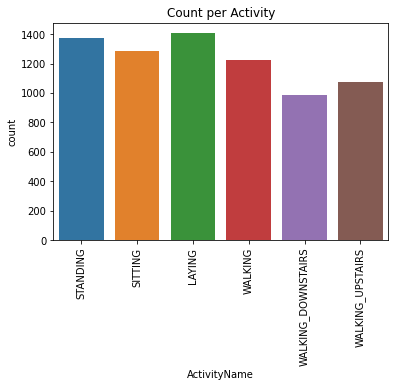

In [70]:
sns.countplot(x ='ActivityName', data = train)
plt.xticks(rotation=90)
plt.title("Count per Activity")

Moving vs Stationary Activities

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

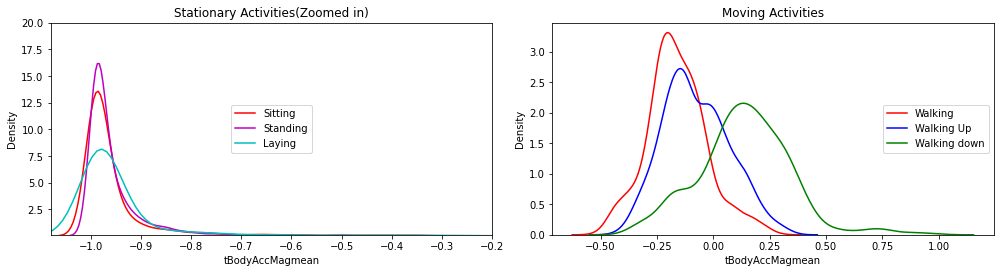

In [71]:
# for plotting purposes taking datapoints of each activity to a different dataframe
df1 = train[train['Activity']==1]
df2 = train[train['Activity']==2]
df3 = train[train['Activity']==3]
df4 = train[train['Activity']==4]
df5 = train[train['Activity']==5]
df6 = train[train['Activity']==6]

plt.figure(figsize=(14,7))
plt.subplot(2,2,1)
plt.title('Stationary Activities(Zoomed in)')
sns.distplot(df4['tBodyAccMagmean'],color = 'r',hist = False, label = 'Sitting')
sns.distplot(df5['tBodyAccMagmean'],color = 'm',hist = False,label = 'Standing')
sns.distplot(df6['tBodyAccMagmean'],color = 'c',hist = False, label = 'Laying')
plt.axis([-1.08, -0.2, 0.1, 20])
plt.legend(loc='center')

plt.subplot(2,2,2)
plt.title('Moving Activities')
sns.distplot(df1['tBodyAccMagmean'],color = 'red',hist = False, label = 'Walking')
sns.distplot(df2['tBodyAccMagmean'],color = 'blue',hist = False,label = 'Walking Up')
sns.distplot(df3['tBodyAccMagmean'],color = 'green',hist = False, label = 'Walking down')
plt.legend(loc='center right')


plt.tight_layout()
plt.show()

# Pre-processing

In [218]:
#save labels as string
X_train = train.drop(['subject', 'Activity','ActivityName'], axis=1)
y_train = train['ActivityName']

In [219]:
conditions = [(train['Activity'] <= 3),(train['Activity'] > 3)]

# create a list of the values we want to assign for each condition
values = ['stationary', 'moving']
y_train_binary = np.select(conditions, values)

In [73]:
X_train.head()

,tBodyAccmeanX,tBodyAccmeanY,tBodyAccmeanZ,tBodyAccstdX,tBodyAccstdY,tBodyAccstdZ,tBodyAccmadX,tBodyAccmadY,tBodyAccmadZ,tBodyAccmaxX,tBodyAccmaxY,tBodyAccmaxZ,tBodyAccminX,tBodyAccminY,tBodyAccminZ,tBodyAccsma,tBodyAccenergyX,tBodyAccenergyY,tBodyAccenergyZ,tBodyAcciqrX,tBodyAcciqrY,tBodyAcciqrZ,tBodyAccentropyX,tBodyAccentropyY,tBodyAccentropyZ,tBodyAccarCoeffX1,tBodyAccarCoeffX2,tBodyAccarCoeffX3,tBodyAccarCoeffX4,tBodyAccarCoeffY1,tBodyAccarCoeffY2,tBodyAccarCoeffY3,tBodyAccarCoeffY4,tBodyAccarCoeffZ1,tBodyAccarCoeffZ2,tBodyAccarCoeffZ3,tBodyAccarCoeffZ4,tBodyAcccorrelationXY,tBodyAcccorrelationXZ,tBodyAcccorrelationYZ,...,fBodyBodyAccJerkMagenergy,fBodyBodyAccJerkMagiqr,fBodyBodyAccJerkMagentropy,fBodyBodyAccJerkMagmaxInds,fBodyBodyAccJerkMagmeanFreq,fBodyBodyAccJerkMagskewness,fBodyBodyAccJerkMagkurtosis,fBodyBodyGyroMagmean,fBodyBodyGyroMagstd,fBodyBodyGyroMagmad,fBodyBodyGyroMagmax,fBodyBodyGyroMagmin,fBodyBodyGyroMagsma,fBodyBodyGyroMagenergy,fBodyBodyGyroMagiqr,fBodyBodyGyroMagentropy,fBodyBodyGyroMagmaxInds,fBodyBodyGyroMagmeanFreq,fBodyBodyGyroMagskewness,fBodyBodyGyroMagkurtosis,fBodyBodyGyroJerkMagmean,fBodyBodyGyroJerkMagstd,fBodyBodyGyroJerkMagmad,fBodyBodyGyroJerkMagmax,fBodyBodyGyroJerkMagmin,fBodyBodyGyroJerkMagsma,fBodyBodyGyroJerkMagenergy,fBodyBodyGyroJerkMagiqr,fBodyBodyGyroJerkMagentropy,fBodyBodyGyroJerkMagmaxInds,fBodyBodyGyroJerkMagmeanFreq,fBodyBodyGyroJerkMagskewness,fBodyBodyGyroJerkMagkurtosis,angletBodyAccMeangravity,angletBodyAccJerkMeangravityMean,angletBodyGyroMeangravityMean,angletBodyGyroJerkMeangravityMean,angleXgravityMean,angleYgravityMean,angleZgravityMean
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,-0.567378,-0.744413,0.852947,0.685845,0.814263,-0.965523,-0.999945,-0.999863,-0.994612,-0.994231,-0.987614,-0.943220,-0.407747,-0.679338,-0.602122,0.929294,-0.853011,0.359910,-0.058526,0.256892,-0.224848,0.264106,-0.095246,0.278851,-0.465085,0.491936,-0.190884,0.376314,0.435129,0.660790,...,-0.999918,-0.991364,-1.0,-0.936508,0.346989,-0.516080,-0.802760,-0.980135,-0.961309,-0.973653,-0.952264,-0.989498,-0.980135,-0.999240,-0.992656,-0.701291,-1.000000,-0.128989,0.586156,0.374605,-0.991990,-0.990697,-0.989941,-0.992448,-0.991048,-0.991990,-0.999937,-0.990458,-0.871306,-1.000000,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,-0.557851,-0.818409,0.849308,0.685845,0.822637,-0.981930,-0.999991,-0.999788,-0.998405,-0.999150,-0.977866,-0.948225,-0.714892,-0.500930,-0.570979,0.611627,-0.329549,0.284213,0.284595,0.115705,-0.090963,0.294310,-0.281211,0.085988,-0.022153,-0.016657,-0.220643,-0.013429,-0.072692,0.579382,...,-0.999867,-0.991134,-1.0,-0.841270,0.532061,-0.624871,-0.900160,-0.988296,-0.983322,-0.982659,-0.986321,-0.991829,-0.988296,-0.999811,-0.993979,-0.720683,-0.948718,-0.271958,-0.336310,-0.720015,-0.995854,-0.996399,-0.995442,-0.996866,-0.994440,-0.995854,-0.999981,-0.994544,-1.000000,-1.000000,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,-0.557851,-0.818409,0.843609,0.682401,0.839344,-0.983478,-0.999969,-0.999660,-0.999470,-0.997130,-0.964810,-0.974675,-0.592235,-0.485821,-0.570979,0.273025,-0.086309,0.337202,-0.164739,0.017150,-0.074507,0.342256,-0.332564,0.239281,-0.136204,0.173863,-0.299493,-0.124698,-0.181105,0.608900,...,-0.999845,-0.986658,-1.0,-0.904762,0.660795,-0.724697,-0.928539,-0.989255,-0.986028,-0.984274,-0.990979,-0.995703,-0.989255,-0.999854,-0.993238,-0.736521,-0.794872,-0.212728,-0.535352,-0.871914,-0.995031,-0.995127,-0.994640,-0.996060,-0.995866,-0.995031,-0.999973,-0.993755,-1.000000,-0.555556,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.

In [74]:
#normalize the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Metrics

In [75]:
def get_dbscan_metrics(targets, c_labels):
  evaluation_results = []
  n_clusters_ = len(set(c_labels)) - (1 if -1 in c_labels else 0)
  evaluation_results.append(n_clusters_)
  evaluation_results.append(metrics.homogeneity_score(targets, c_labels))
  evaluation_results.append(metrics.completeness_score(targets, c_labels))
  evaluation_results.append(metrics.v_measure_score(targets, c_labels))
  evaluation_results.append(metrics.adjusted_rand_score(targets,c_labels))
  evaluation_results.append(metrics.adjusted_mutual_info_score(targets, c_labels))
  return evaluation_results

In [76]:
from prettytable import PrettyTable
def print_metrics(name_model, evaluation_results):
  labels = ['name','no_clusters', 'homo','compl','v-meas','ARI','AMI']
  results = evaluation_results  
  results = [ '%.2f' % elem for elem in results ]
  results.insert(0, name_model)
  t = PrettyTable(labels)
  t.add_row(results)
  return t

In [248]:
# Plot the clusters
def plot_dbscan_cluster(ax,title,dataframe,labels):
  ax.scatter(dataframe[:, 0], dataframe[:,1], c = labels, cmap= "plasma") 
  ax.title.set_text(title)
  ax.set_xlabel("Component 1")
  ax.set_ylabel("Component 2")

# DBSCAN

In [77]:
def getDbscan(eps, min_samples, data_frame):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(data_frame)
    dbscan.fit(data_frame)
    c_labels = dbscan.labels_
    return c_labels

In [279]:
def findDBSCANOptimalEpsilon(features,ns):
  noOfPointsYouHave = len(features)
  nbrs = NearestNeighbors(n_neighbors=ns).fit(features)
  distances, indices = nbrs.kneighbors(features)
  distanceDec = sorted(distances[:,ns-1], reverse=True)
  plt.figure(figsize=(20,10))
  plt.title("find optimal epsilon")
  plt.plot(list(range(1,noOfPointsYouHave+1)), distanceDec)

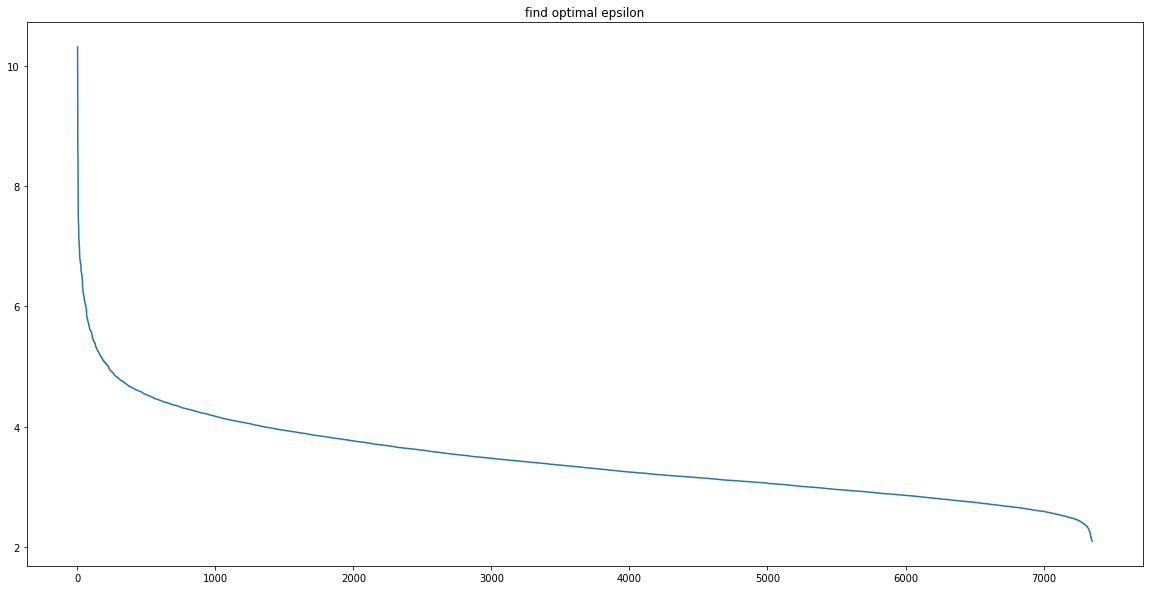

In [280]:
findDBSCANOptimalEpsilon(X_train,4)

In [270]:
cluster_labels = getDbscan(3, 25, X_train)
evaluation_metrics = get_dbscan_metrics(y_train_binary,cluster_labels)
print(print_metrics('plain',evaluation_metrics))

+-------+-------------+------+-------+--------+------+------+
|  name | no_clusters | homo | compl | v-meas | ARI  | AMI  |
+-------+-------------+------+-------+--------+------+------+
| plain |     3.00    | 0.17 |  0.20 |  0.18  | 0.03 | 0.18 |
+-------+-------------+------+-------+--------+------+------+


# PCA

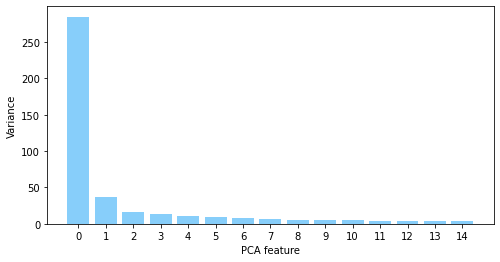

In [101]:
#check for optimal number of features
pca = PCA(random_state=123)
pca.fit(X_train)
features = range(pca.n_components_)

plt.figure(figsize=(8,4))
plt.bar(features[:15], pca.explained_variance_[:15], color='lightskyblue')
plt.xlabel('PCA feature')
plt.ylabel('Variance')
plt.xticks(features[:15])
plt.show()

In [102]:
def pca_transform(n_comp,data):
    pca = PCA(n_components=n_comp, random_state=123)
    dataReduced = pca.fit_transform(data)
    print('Shape of the new Data df: ' + str(dataReduced.shape))
    return dataReduced

Shape of the new Data df: (7352, 2)


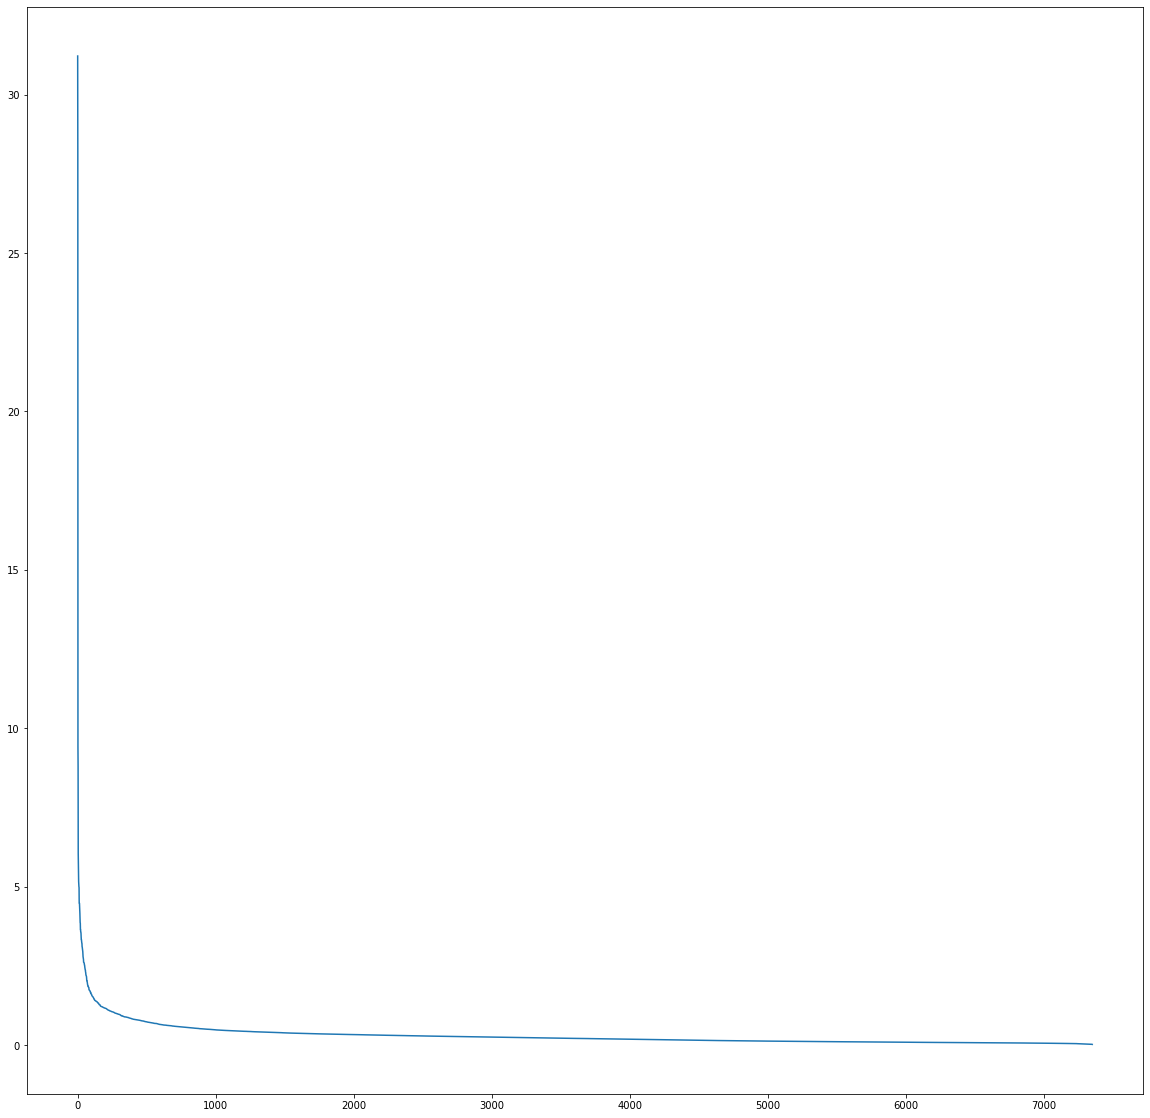

In [212]:
X_train_pca = pca_transform(n_comp=2, data=X_train)
findDBSCANOptimalEpsilon(X_train_pca,4)

+------+-------------+------+-------+--------+------+------+
| name | no_clusters | homo | compl | v-meas | ARI  | AMI  |
+------+-------------+------+-------+--------+------+------+
| PCA  |     2.00    | 0.98 |  0.92 |  0.95  | 0.98 | 0.95 |
+------+-------------+------+-------+--------+------+------+


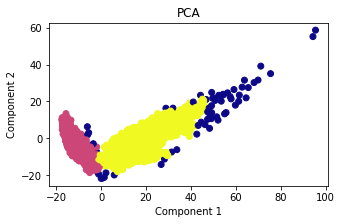

In [238]:
cluster_labels_pca = getDbscan(2, 6, X_train_pca)
evaluation_metrics = get_dbscan_metrics(y_train_binary,cluster_labels_pca)
print(print_metrics('PCA',evaluation_metrics ))

fig, ax = plt.subplots()
plot_dbscan_cluster(ax,"PCA", X_train_pca, cluster_labels_pca)

# Evaluation 




Computer efficieny methods

In [86]:
# The first function is to stop the tracing, if any, and to start the fresh tracing. 
# This ensures that the tracing of 2 code blocks doesn’t interfere with each other. 
def tracing_start():
    tracemalloc.stop()
    print("nTracing Status : ", tracemalloc.is_tracing())
    tracemalloc.start()
    print("Tracing Status : ", tracemalloc.is_tracing())

# The second function is to find the peak size in MB of a block of code that was traced.
def tracing_mem():
    first_size, first_peak = tracemalloc.get_traced_memory()
    peak = first_peak/(1024*1024)
    print("peak in MB:  " + str(peak))
    return peak

In [281]:
# PCA
tracing_start()
start = time.time()
cluster_labels_pca = getDbscan(2, 4, X_train_pca)
evaluation_metrics_pca = get_dbscan_metrics(y_train,cluster_labels)
end = time.time()
pca_time = (end-start)*1000
print("time elapsed PCA {} milli seconds".format(pca_time))
pca_peak = tracing_mem()

# normal
tracing_start()
start = time.time()
cluster_labels_normal = getDbscan(2, 4, X_train)
evaluation_metrics_normal = get_dbscan_metrics(y_train,cluster_labels)
end = time.time()
normal_time = (end-start)*1000
print("time elapsed normal {} milli seconds".format(normal_time))
normal_peak = tracing_mem()

nTracing Status :  False
Tracing Status :  True
time elapsed PCA 614.2058372497559 milli seconds
peak in MB:  2.0157012939453125
nTracing Status :  False
Tracing Status :  True
time elapsed normal 4430.8648109436035 milli seconds
peak in MB:  414.1882162094116


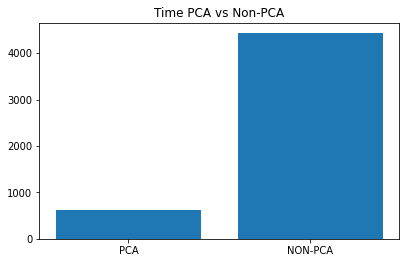

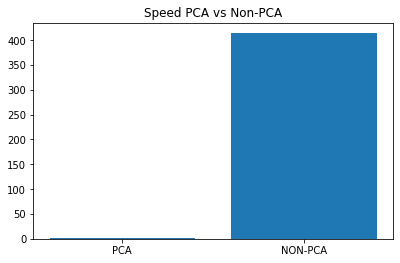

In [282]:
# Plot time
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['PCA','NON-PCA']
times_miliseconds = [pca_time,normal_time]
ax.bar(labels,times_miliseconds)
plt.title("Time PCA vs Non-PCA")
plt.show()

# Plot speed
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['PCA','NON-PCA']
peak_MB = [pca_peak,normal_peak]
ax.bar(labels,peak_MB)
plt.title("Speed PCA vs Non-PCA")
plt.show()

Evaluation Clustering metrics

+--------+-------------+---------------------+---------------------+--------------------+----------------------+---------------------+
|  name  | no_clusters |         homo        |        compl        |       v-meas       |         ARI          |         AMI         |
+--------+-------------+---------------------+---------------------+--------------------+----------------------+---------------------+
| normal |     3.00    |         0.12        |         0.37        |        0.18        |         0.02         |         0.18        |
|  pca   |      3      | 0.11920814526311838 | 0.37420878029737803 | 0.1808155834530846 | 0.022179667515424648 | 0.18009961531835847 |
+--------+-------------+---------------------+---------------------+--------------------+----------------------+---------------------+
type pca :<class 'numpy.ndarray'>
type nrom :<class 'pandas.core.frame.DataFrame'>


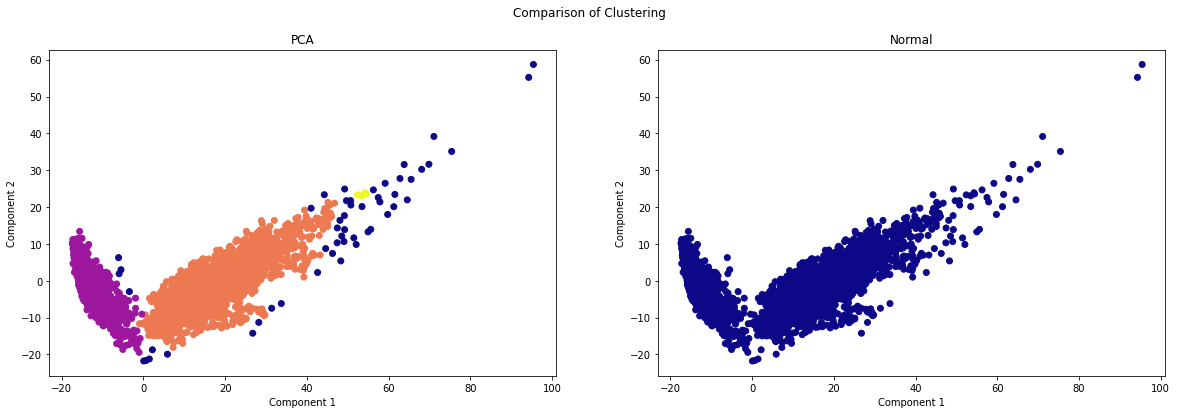

In [283]:
t = print_metrics('normal',evaluation_metrics_normal)
evaluation_metrics_pca.insert(0,"pca")
t.add_row(evaluation_metrics_pca)
print(t)

print("type pca :" + str(type(X_train_pca)))
print("type nrom :" + str(type(X_train)))

# both use pca for visual comparison
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,6))
fig.suptitle('Comparison of Clustering')
plot_dbscan_cluster(ax1,"PCA", X_train_pca, cluster_labels_pca)
plot_dbscan_cluster(ax2,"Normal", X_train_pca, cluster_labels_normal)